### The Persistence of Memory
Author: catwong@stanford.edu; Date: May 16, 2018

Project goals: model hippocampal memory trace formation as preserving neural network activations in response to inputs, and consolidation as increasing sparsity in the stored representations.

- Task 1: do simple, PCA-based sparse representations of CNN layers lead to valid predictions?
- Task 2: do increasingly sparse representations correlate with the empirical features of perceptual gists?
- Task 3: can training on sparse CNN gradients, especially within more semantic layers, yield meaningful updates? Can it lead to faster and more generalized learning (ie. in a one-shot scenario)? Can it avoid catastrophic interference?



# Model Import

In [34]:
from __future__ import division
import os
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

from skimage import io, transform, color
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
ALEXNET_PATH = 'alexnet.pth'
VAL_DIRECTORY_PATH = 'datasets/tiny-imagenet-200/val'
CLASS_MAP_LABELS = 'datasets/tiny-imagenet-200/map_clsloc.txt'

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

use_cuda = torch.cuda.is_available()
print "Use CUDA:" + str(use_cuda)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Use CUDA:True


In [2]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [3]:
def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(ALEXNET_PATH))
    return model

model = alexnet()

## Utility Functions

In [50]:
# Dataset cleanup: create an annotations file with imagenet classes, indices, and annotations
def write_labeled_annotations_file(root_dir, raw_annotations_file, output_file):
    class_labels = pd.read_csv(CLASS_MAP_LABELS, sep=' ', header=None)
    raw_annotations = pd.read_csv(os.path.join(root_dir, raw_annotations_file), sep='\t', header=None)
    # Create map from class names to labels
    labels_to_classes_map = {}
    for i in range(len(class_labels)):
        label, index, semantic = class_labels.iloc[i, 0], str(class_labels.iloc[i, 1] - 1), class_labels.iloc[i, 2]
        labels_to_classes_map[label] = (index, semantic)
    
    # Remap the raw annotations file
    with open(os.path.join(root_dir, output_file), 'w') as f:
        for i in range(len(raw_annotations)):
            image_file, label = raw_annotations.iloc[i, 0], raw_annotations.iloc[i, 1]
            f.write("\t".join((image_file, labels_to_classes_map[label][0], label, labels_to_classes_map[label][1])) + "\n")    

    
write_labeled_annotations_file(VAL_DIRECTORY_PATH, 'val_annotations.txt', 'annotations.txt')

Total images: 10000
Index: 944 Label: n04371430 Semantic: swimming_trunks
Size: (64, 64, 3)


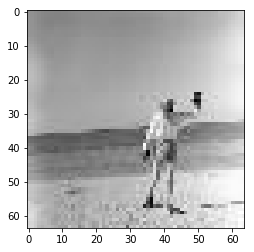

In [39]:
# Dataset
class TinyImageNetDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None):
        """
        annotations_file: tab separated file with img_file, 1000-class index, ImageNet label, semantic-label 
        """
        self.annotations_file = pd.read_csv(os.path.join(root_dir, annotations_file), sep='\t', header=None)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations_file)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'images',
                                self.annotations_file.iloc[idx, 0])
        image = io.imread(img_name)
        if len(image.shape) == 2:
            image = color.gray2rgb(image)
        sample = {'image': image, 
                  'index': self.annotations_file.iloc[idx, 1], 
                  'label': self.annotations_file.iloc[idx, 2],
                  'semantic': self.annotations_file.iloc[idx, 3]}
        if self.transform:
            sample = self.transform(sample)
        return sample

# Demo
tiny_dataset = TinyImageNetDataset('annotations.txt', VAL_DIRECTORY_PATH)
print "Total images: " + str(tiny_dataset.__len__())
sample = tiny_dataset.__getitem__(10)
print "Index: %d Label: %s Semantic: %s" % (sample['index'], sample['label'], sample['semantic'])
print "Size: " + str(sample['image'].shape)
plt.imshow(sample['image'])

In [41]:
# Dataloader Demo
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, index, label, semantic = sample['image'], sample['index'], sample['label'], sample['semantic']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'index': index, 'label': label, 'semantic': semantic}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, index, label, semantic = sample['image'], sample['index'], sample['label'], sample['semantic']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'index': index, 'label': label, 'semantic': semantic}

def get_tiny_dataloader(annotations_file='annotations.txt', 
                        root_dir=VAL_DIRECTORY_PATH, 
                        batch_size=4,
                        num_workers=1):

    val_loader = DataLoader(
        TinyImageNetDataset(annotations_file, root_dir, transforms.Compose([
            Rescale(256),
            ToTensor(),
        ])),
        batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True)
    return val_loader


tiny_dataloader = get_tiny_dataloader()

for i_batch, sample_batched in enumerate(tiny_dataloader):
    print(i_batch, len(sample_batched['image']), len(sample_batched['semantic']))
    if i_batch > 7:
        break
        
     
        

(0, 4, 4)
(1, 4, 4)
(2, 4, 4)
(3, 4, 4)
(4, 4, 4)
(5, 4, 4)
(6, 4, 4)
(7, 4, 4)
(8, 4, 4)


## Task 1: Sparsity for Image Predictions

In [12]:
## Demo: AlexNet forward pass on images.
